In [15]:
#import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import sklearn 

#### Import data + Process

In [72]:
#Import data - read arrhythmia.data file comma-delimited
ar_df = pd.read_csv('arrhythmia.data', sep=',', header = None, usecols = [0, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])

#Label the first 15 columns with labels according to arrhythmia.names file 
ar_df.columns = ['Age','Weight', 'QRS Duration', 'P-R Interval', 'Q-T Interval', 'T-Interval', 
                                                        'P-Interval', 'QRS', 'T', 'P', 'QRST']
#inspect DataFrame
ar_df.head()

#reset index to simplify for processing
ar_df.reset_index(drop=True, inplace=True)

#drop missing data/NaN 
ar_df.replace('?', np.nan, inplace=True)
ar_df = ar_df.dropna()

#inspect new DataFrame with index
ar_df.head()

,Age,Weight,QRS Duration,P-R Interval,Q-T Interval,T-Interval,P-Interval,QRS,T,P,QRST
0,75,80,91,193,371,174,121,-16,13,64,-2
1,56,64,81,174,401,149,39,25,37,-17,31
2,54,95,138,163,386,185,102,96,34,70,66
3,55,94,100,202,380,179,143,28,11,-5,20
4,75,80,88,181,360,177,103,-16,13,61,3


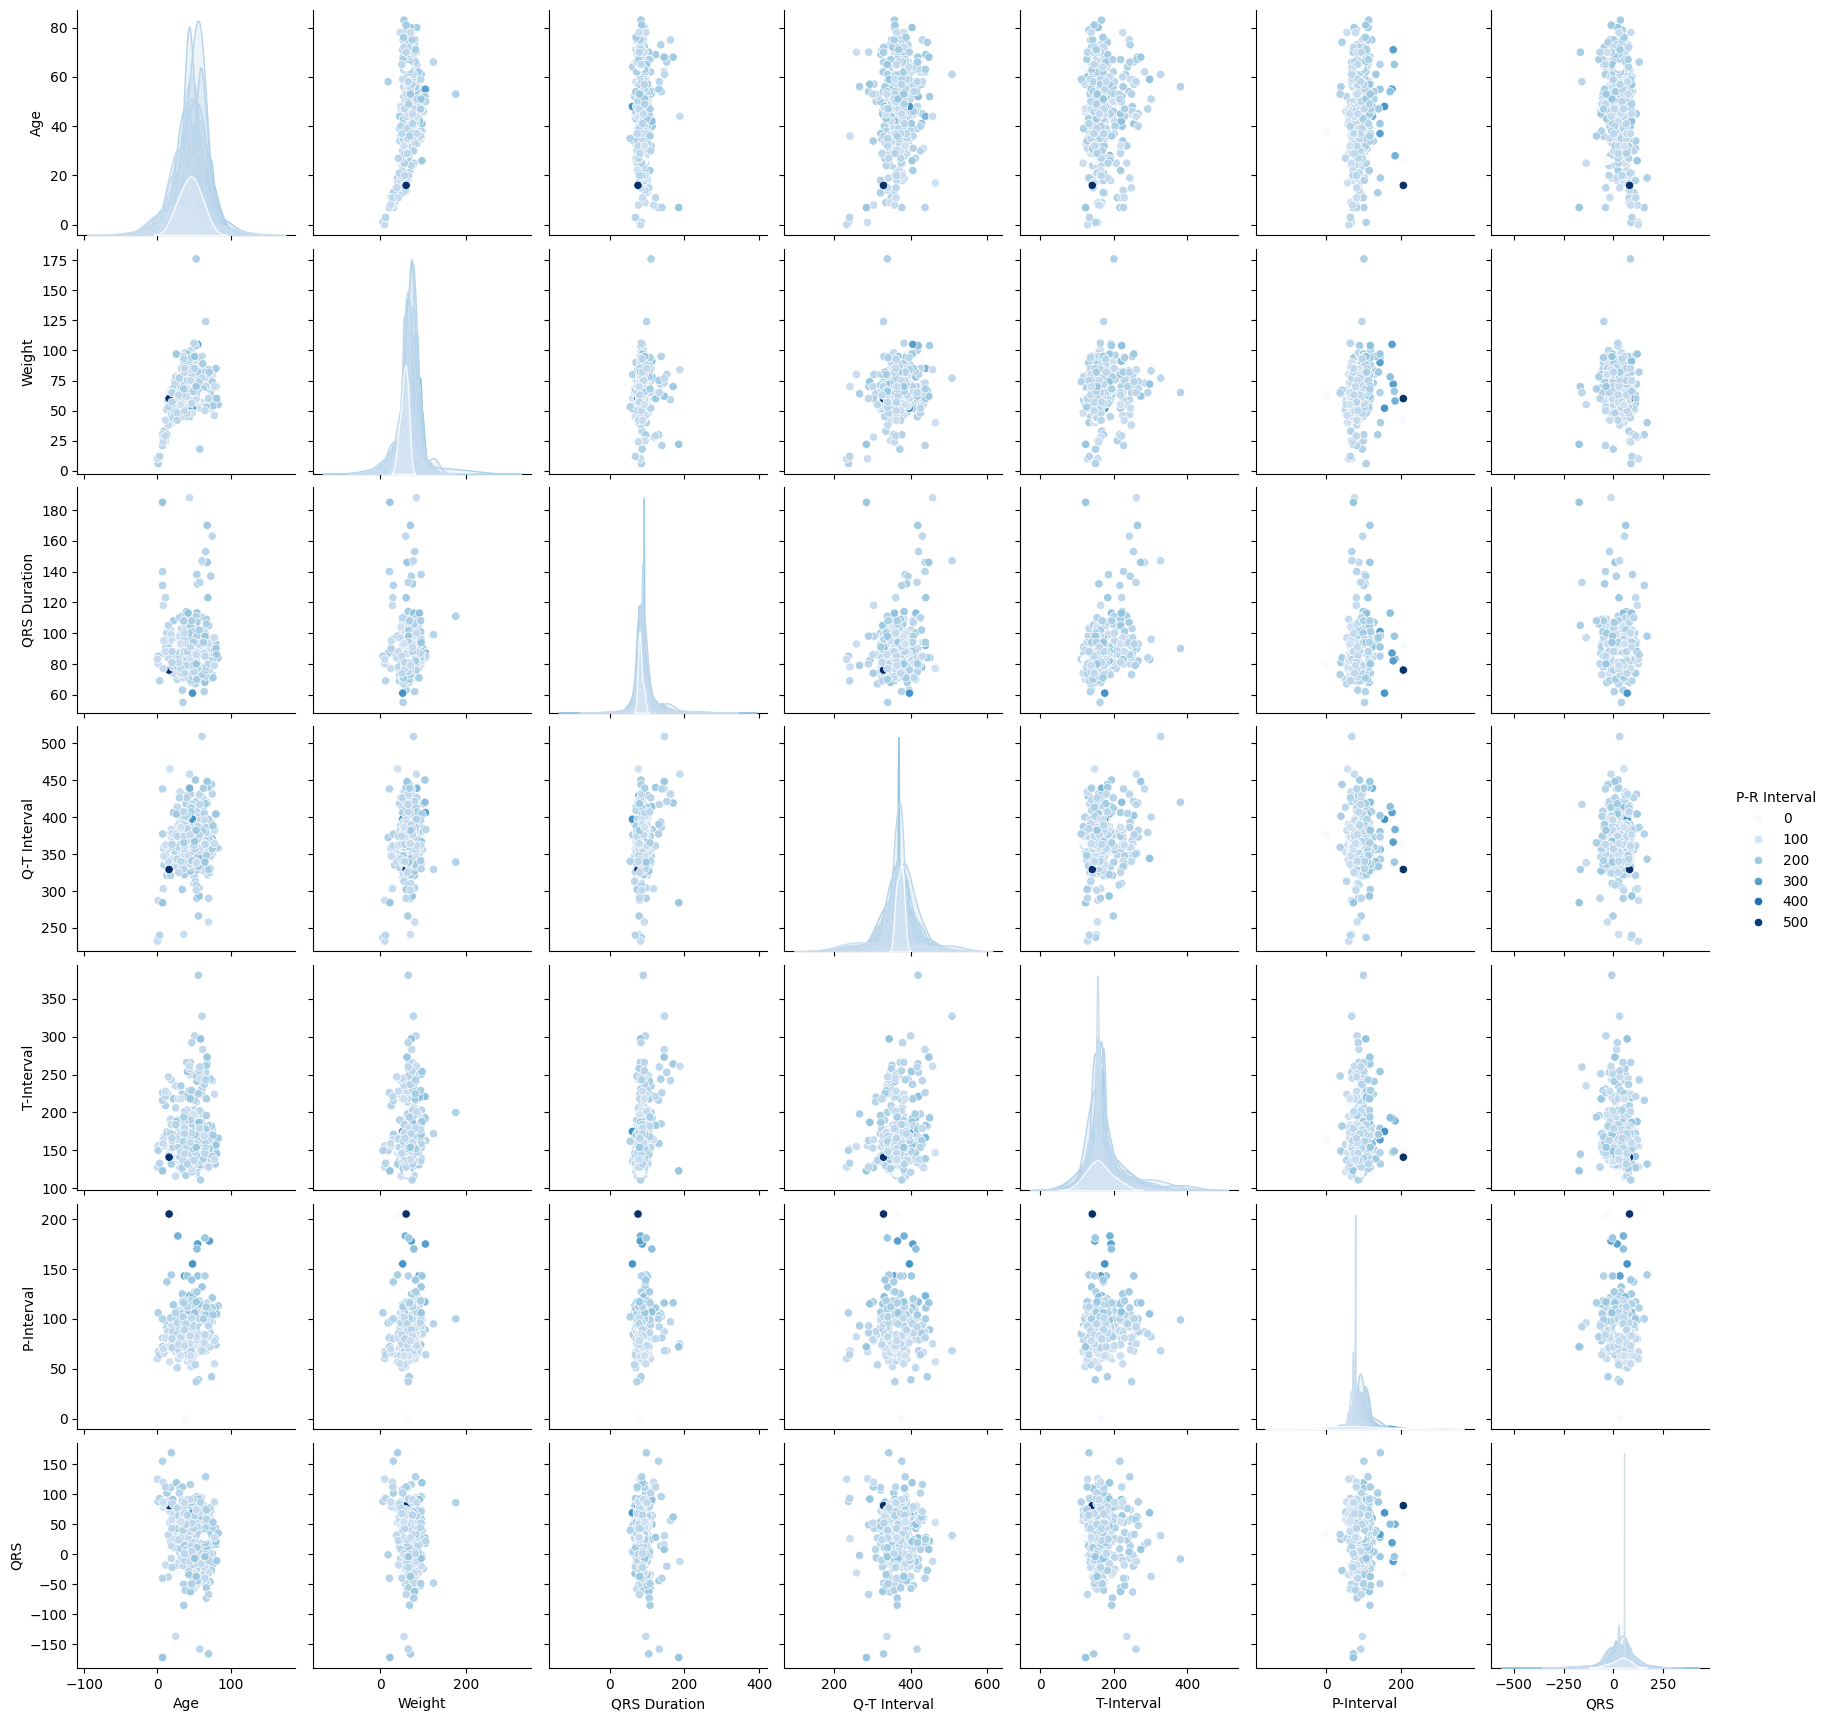

In [73]:
#Use Seaborn to look at data distribution and determine which plot to use for assignment
sns.pairplot(ar_df, hue = 'P-R Interval', palette = 'Blues')

In [74]:
#Select P-R Interval for grouping data, idea being that P-R interval changes can dictate risk of atrial fibrillation and other arrhythmias
k_df = ar_df[['Age', 'Weight', 'P-R Interval']]
k_df.head()

,Age,Weight,P-R Interval
0,75,80,193
1,56,64,174
2,54,95,163
3,55,94,202
4,75,80,181


### Q1
- Demonstrate k-means clustering using the scikit learn package (50 points).                                             

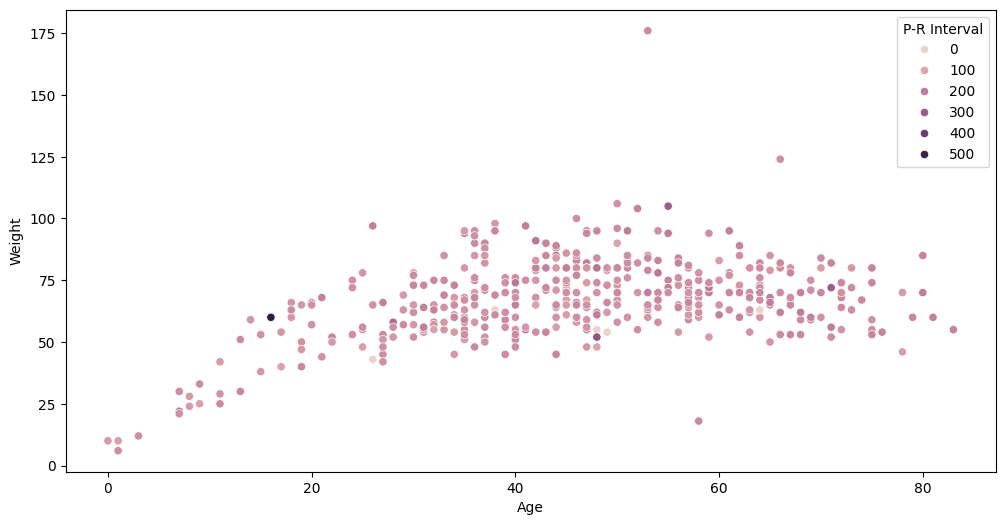

In [31]:
#plot figure for reference 

plt.figure(figsize=(12, 6))
sns.scatterplot(data = k_df, x = 'Age', y = 'Weight', hue = 'P-R Interval')
plt.show()

In [81]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

#use StandardScaler to ensure features with different scales do not dominate clustering as variables are of vastly different scales.
scaler = StandardScaler()
scaled_df = scaler.fit_transform(k_df)

k = 5  # trial with 5 clusters, will use elbow (below) to determine optimal amount of clusters 
kmeans = KMeans(n_clusters=k)
kmeans.fit(scaled_df)

# Add cluster column to the original dataframe
k_df.loc[:, 'Cluster'] = kmeans.labels_

k_df.head()

,Age,Weight,P-R Interval,Cluster
0,75,80,193,1
1,56,64,174,1
2,54,95,163,3
3,55,94,202,3
4,75,80,181,1


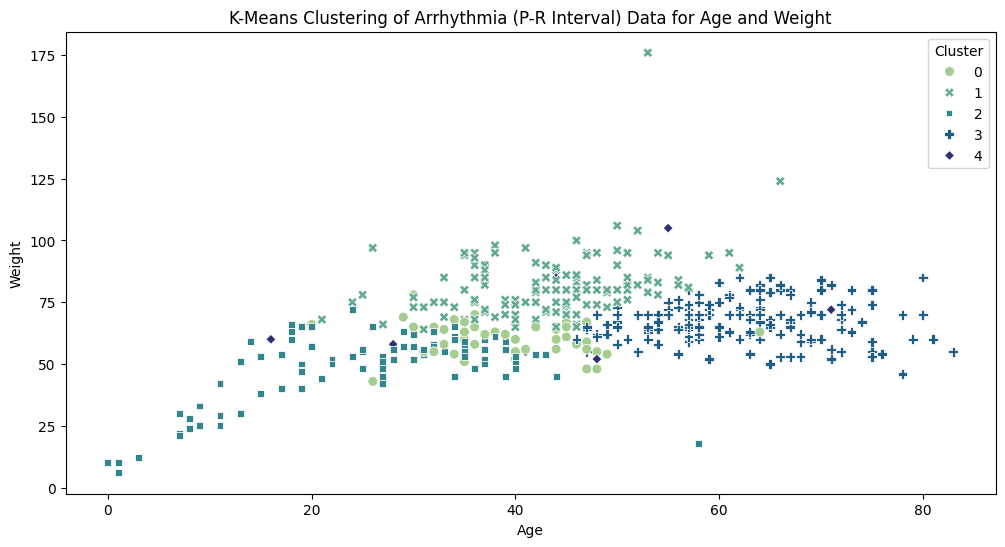

In [59]:
#Create plot to show clustered data 

# Visualize the clusters (using two features at a time), return to k_df as cluster column added to dataframe was created using scaled_df therefore pertinent/appropriate to return to original df(k_df)
plt.figure(figsize=(12, 6))
sns.scatterplot(
    x=k_df['Age'], 
    y=k_df['Weight'],
    hue=k_df['Cluster'], #hue based on cluster 0, 1, 2
    palette='crest', #color palette - crest
    style=k_df['Cluster'], #differentiate cluster based on shape of marker
    s=50
)

plt.title("K-Means Clustering of Arrhythmia (P-R Interval) Data for Age and Weight")
plt.xlabel("Age")
plt.ylabel("Weight")
plt.legend(title="Cluster")
plt.show()

### Q2
- Calculate the sum of least square error for each different values of 'k'.
- Using Matplotlib determine the optimal number of clusters (k) using the elbow method along with a brief explanation (50 points) 

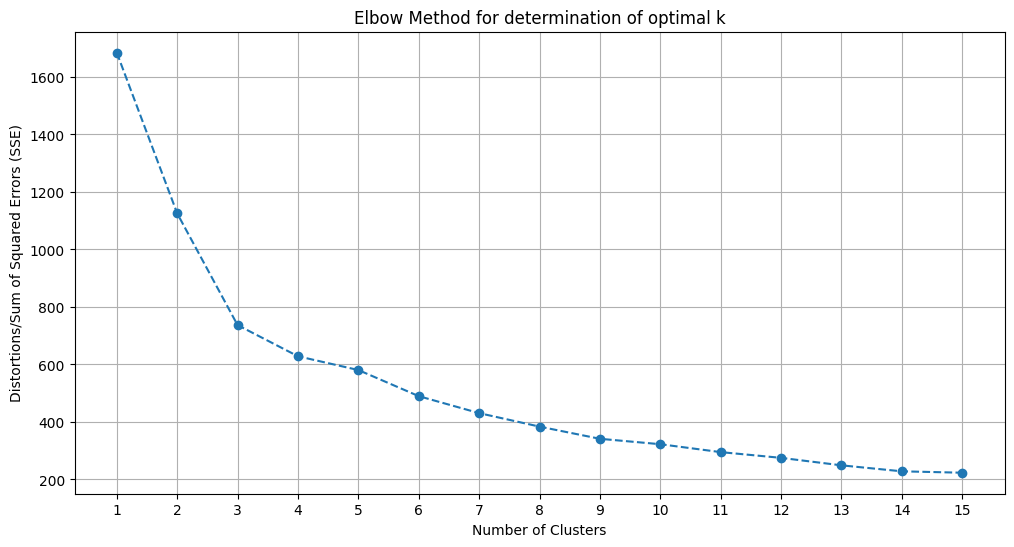

In [82]:
#Testing k values between 1 and 16 (based on arrhythmia data that illustrates that there are 16 groups/potential for 16 clusters)
k_values = range(1, 16) 

# Calculate distortion for each k to create elbow plot, based on example: https://towardsdatascience.com/k-means-clustering-with-scikit-learn-6b47a369a83c

distortions = [] #(sum of least squared) 
for k in k_values:
    kmeans = KMeans(n_clusters=k, init='random',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0
    )
    kmeans.fit(scaled_df) 
    distortions.append(kmeans.inertia_) #calculates sum of least squared/inertia for k-means clustering 


# Plot the Elbow Method
plt.figure(figsize=(12, 6))
plt.plot(k_values, sse, marker='o', linestyle='--')
plt.title('Elbow Method for determination of optimal k')
plt.xlabel('Number of Clusters')
plt.ylabel('Distortions/Sum of Squared Errors (SSE)')
plt.xticks(k_values) #label k values used
plt.grid()
plt.show()

##### Based on the above elbow graph it appears that the optimal number of clusters is 3, i.e. the point where the elbow is located
- this point will be used for Question 3

- K-means works well, however it relies on specifying the number of clusters (k) without knowing what k is optimal. The number of clusters in the arrhythmia dataset is not obvious on the plotted dataset so using the elbow method for this determination is warranted.

- the elbow method is a useful graphical tool to estimate the optimal k value because as k increased, the within-cluster SSE (distortion) decreases as samples are closer to the centroids

- at k = 3 the distortion decrases the most rapidly, and therefore this is the optimum value of k

### Q3
- plot the optimal clusters with their centroids along with a brief explanation (50 points).

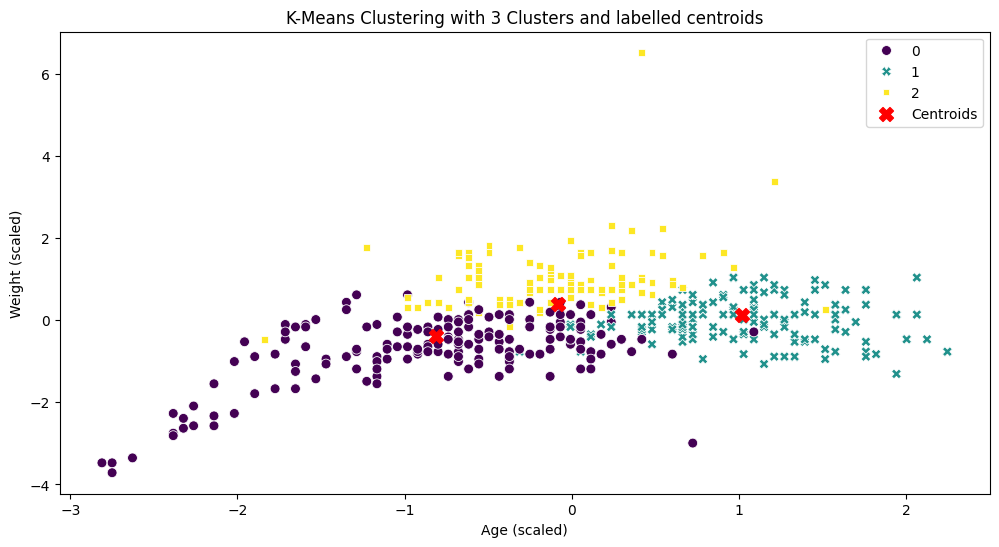

In [89]:
# Optimal number of clusters from the elbow method shown above 
optimal_k = 3  

# Fit the KMeans model with optimal k
kmeans_optimal = KMeans(n_clusters=optimal_k, random_state=0)
kmeans_optimal.fit(scaled_df) #return to using scaled_df for scaled data 

# Get cluster labels and centroids
k_df.loc[:, 'Clusters'] = kmeans_optimal.labels_# Add clusters labels to the DataFrame (slightly different than cluster to keep track of difference)
centroids = kmeans_optimal.cluster_centers_  # Centroids in scaled space

# Plot the clusters and centroids
plt.figure(figsize=(12, 6))
sns.scatterplot(
    x=scaled_df[:, 0],  # Scaled 'age'
    y=scaled_df[:, 1],  # Scaled 'p-r interval'
    hue=k_df['Clusters'],
    palette='viridis',
    style=k_df['Clusters'],
    s=50,
    legend='full'
)

# Plot centroids
plt.scatter(
    centroids[:, 0],  # Scaled 'age'
    centroids[:, 2],  # Scaled 'p-r interval'
    c='red',
    marker='X',
    s=100,
    label='Centroids'
)

plt.title(f"K-Means Clustering with {optimal_k} Clusters and labelled centroids")
plt.xlabel('Age (scaled)')
plt.ylabel('Weight (scaled)')
plt.legend()
plt.show()


##### Data shows the centroids associated with each cluster for k = 3 cluster (which is the optimum number of clusters based on the elbow graph plotted above. 

###### There is no clear separation of these data for clustering which is one of the reasons that using this method is important as it is not possible to visualize with naked eye regarding the most appropriate number of clusters. Therefore, using the elbow graph and the associated centroids we can see the most appropriate information surrounding the P-R interval and Age/Weight to cluster these data accordingly and provide potential insights. 